<IPython.core.display.Javascript object>


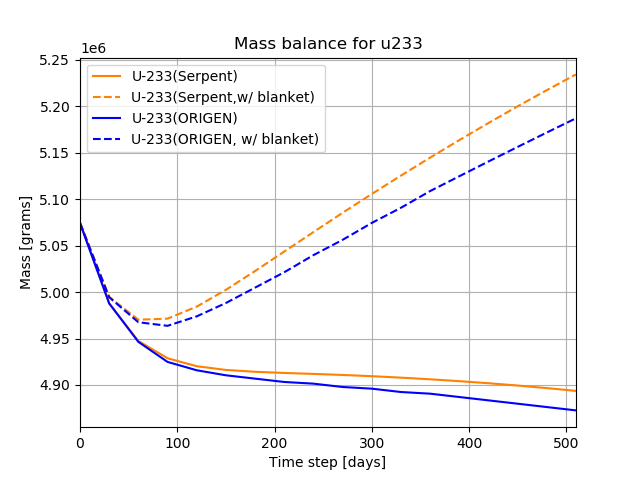

<IPython.core.display.Javascript object>


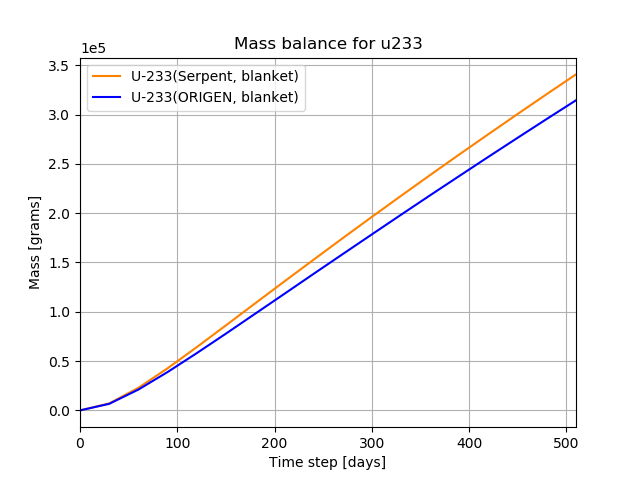

Correlation between mass of target isotope (Serpent-Unit vs SCALE-Unit) is (0.9944115491721882, 4.700137871477455e-17)
Relative error for fuel salt in target isotope mass after 510.0 days: 0.42925118639694343 %
Relative error in total target isotope mass after 510.0 days: 0.9026012487346251 %
Relative error in blanket in total target isotope mass after 510.0 days: 7.70101309458082 %

From SCALE
Breeding gain 80.7895294117647 kg/year
Breeding gain coefficient 0.022246659
Breeding gain in blanket 225.07187370210886 kg/year

Doubling time (net) 125.61528794500163

From Serpent
Breeding gain 114.03538980392231 kg/year
Breeding gain coefficient 0.031396526339352075
Breeding gain in blanket 243.85086039215685 kg/year

Doubling time (net) 89.00731621518851


In [28]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
import itertools

dep0 = serpent.parse_dep('/home/andrei2/Desktop/ornl/msfr/serpent/no_repr_depletion/msfr_depl.inp_dep.m', make_mats=False)
days = dep0['DAYS']                             # Time array parsed from *_dep.m file
n_se    = dep0['NAMES'][0].split()                 # Names of isotopes parsed from *_dep.m file
EOC = np.amax(days)                             # End of cycle (simulation time length)
total_mass_list = dep0['TOT_MASS']
adens_fuel_se      = dep0['MAT_fuel_ADENS']        # atomic density for each isotope in material 'fuel'
mdens_fuel_se      = dep0['MAT_fuel_MDENS']        # mass density for each isotope in material 'fuel'
vol_fuel_se        = dep0['MAT_fuel_VOLUME']       # total volume of material 'fuel'
adens_blank_se     = dep0['MAT_blank_ADENS']       # atomic density for each isotope in material 'blank'
mdens_blank_se     = dep0['MAT_blank_MDENS']       # mass density for each isotope in material 'blank'
vol_blank_se       = dep0['MAT_blank_VOLUME']      # total volume of material 'blank'
# SCALE output 
filename_fuel  = '/home/andrei2/Desktop/ornl/msfr/scale/no_reproc_depl/510efpd/anl425/quarter_cell2.000000000000000000.plt'
filename_blank = '/home/andrei2/Desktop/ornl/msfr/scale/no_reproc_depl/510efpd/anl425/quarter_cell2.000000000000000001.plt'
#print (dep0.keys())
#print (adens_fuel)
#print (n.index('Th232'))

def read_scale_out (filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]))
            adens.append(p[1:])  
            #iso.append(str(p[2]))
            #adens.append(str(p[3]))
    #u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    #flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    #num_gr = len (u_en)
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days, adens_arr

n_sc, days_sc, mdens_fuel_sc          = read_scale_out (filename_fuel)
n_sc_blanket, days_sc, mdens_blank_sc = read_scale_out (filename_blank)

#print (adens_fuel_sc[10])
vol_fuel_se = [18.0E+6]
vol_blank_se = [7.3E+6]

iso = 'u233'
tot_mass_se = mdens_fuel_se[n_se.index(iso.capitalize()),]*vol_fuel_se+mdens_blank_se[n_se.index(iso.capitalize()),]*vol_blank_se
tot_mass_sc = mdens_fuel_sc[n_sc.index(iso),]*vol_fuel_se[0]+mdens_blank_sc[n_sc_blanket.index(iso),]*vol_blank_se[0]
gain_rate = 1e-3*365*(tot_mass_sc[-1] - tot_mass_sc[0])/days[-1]
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#ax.set_ylim(0,0.00555)
#plot_title = 'Relative error in mass ' + str(100*abs(mdens_fuel_sc[n_sc.index(iso),-1]-mdens_fuel_se[n_se.index(iso.capitalize()),-1])/ 
#           mdens_fuel_se[n_se.index(iso.capitalize()),-1] ) + ' %\n'
for i in [n_se.index(iso.capitalize())]:
    ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent)')
    ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0]+mdens_blank_se[i,:]*vol_blank_se[0], '--',color='#ff8100',
            label=nucname.serpent(n_se[i])+'(Serpent,w/ blanket)')
    #ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent, blanket)')
for k in [n_sc.index(iso)]:
    ax.plot(days_sc, mdens_fuel_sc[k]*vol_fuel_se[0], '-',color='blue', label=nucname.serpent(n_sc[k])+'(ORIGEN)')
for k in [n_sc_blanket.index(iso)]:
    ax.plot(days_sc, mdens_blank_sc[k] * vol_blank_se[0] + mdens_fuel_sc[n_sc.index(iso)] * vol_fuel_se[0],
            '--',color='blue',label=nucname.serpent(n_sc_blanket[k])+'(ORIGEN, w/ blanket)')
#for k in [n_sc_blanket.index(iso)]:
#    ax.plot(days_sc, mdens_blank_sc[k]*vol_blank_se[0], '-',color='blue', label=nucname.serpent(n_sc_blanket[k])+'(ORIGEN, blanket)')
ax.legend(loc=0)
ax.set_ylabel('Mass [grams]')
ax.set_xlabel('Time step [days]')
ax.set_title('Mass balance for ' + str (iso))
#ax.text(0.95, 0.5, 'Breeding gain  '+"{0:.1f}".format(gain_rate)+ ' kg/year', 
#        horizontalalignment='right',verticalalignment='center', transform=ax.transAxes)
#ax.text(0.95, 0.45, 'Breeding gain coeff  '+"{0:.4f}".format((tot_mass_sc[-1] - tot_mass_sc[0])/(tot_mass_sc[0])), 
#        horizontalalignment='right',verticalalignment='center', transform=ax.transAxes)
ax.set_xlim([0,np.amax(days_sc)])
fig_1.show()
#fig_1.savefig(str(iso)+'__anl230v71.png',format='png')

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
for i in [n_se.index(iso.capitalize())]:
    ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent, blanket)')
for k in [n_sc_blanket.index(iso)]:
    ax.plot(days_sc, mdens_blank_sc[k]*vol_blank_se[0], '-',color='blue', label=nucname.serpent(n_sc_blanket[k])+'(ORIGEN, blanket)')
ax.legend(loc=0)
ax.set_ylabel('Mass [grams]')
ax.set_xlabel('Time step [days]')
ax.set_title('Mass balance for ' + str (iso))
ax.set_xlim([0,np.amax(days_sc)])
fig_2.show()
#fig_2.savefig(str(iso)+'_blanket_anl230v71.png',format='png')

print ("Correlation between mass of target isotope (Serpent-Unit vs SCALE-Unit) is "
           + str(pearsonr(mdens_fuel_sc[n_sc.index(iso)], mdens_fuel_se[n_se.index(iso.capitalize())]))  )
print ('Relative error for fuel salt in target isotope mass after ' + str(days[-1]) + ' days: ' + 
       str(100*abs(mdens_fuel_sc[n_sc.index(iso),-1]-mdens_fuel_se[n_se.index(iso.capitalize()),-1])/ 
           mdens_fuel_se[n_se.index(iso.capitalize()),-1] ) + ' %') 
print ('Relative error in total target isotope mass after ' + str(days[-1]) + ' days: ' + 
       str (100*abs(tot_mass_se[-1]-tot_mass_sc[-1]) / tot_mass_se[-1]) + ' %'    )
print ('Relative error in blanket in total target isotope mass after ' + str(days[-1]) + ' days: ' + 
       str (100*abs(mdens_blank_sc[n_sc_blanket.index(iso),-1]-mdens_blank_se[n_se.index(iso.capitalize()),-1]) / mdens_blank_se[n_se.index(iso.capitalize()),-1]) + ' %'    )

print ('\nFrom SCALE')
print ('Breeding gain ' + str (1e-3*365*(tot_mass_sc[-1] - tot_mass_sc[0])/days[-1]) + ' kg/year' )
print ('Breeding gain coefficient ' + str ((tot_mass_sc[-1] - tot_mass_sc[0])/(tot_mass_sc[0])) )
print ('Breeding gain in blanket ' + str (1e-3*365*(mdens_blank_sc[n_sc_blanket.index(iso),-1]*vol_blank_se[0] - mdens_blank_sc[n_sc_blanket.index(iso),0]*vol_blank_se[0])/days[-1]) + ' kg/year' )
print ('\nDoubling time (net) ' + str( 2*tot_mass_sc[0]/ (365*(tot_mass_sc[-1] - tot_mass_sc[0])/days[-1] )) )
print ('\nFrom Serpent')
print ('Breeding gain ' + str (1e-3*365*(tot_mass_se[-1] - tot_mass_se[0])/days[-1]) + ' kg/year' )
print ('Breeding gain coefficient ' + str ((tot_mass_se[-1] - tot_mass_se[0])/(tot_mass_se[0])) )
print ('Breeding gain in blanket ' + str (1e-3*365*(mdens_blank_se[n_se.index(iso.capitalize()),-1]*vol_blank_se[0] - mdens_blank_se[n_se.index(iso.capitalize()),0]*vol_blank_se[0])/days[-1]) + ' kg/year' )
print ('\nDoubling time (net) ' + str( 2*tot_mass_se[0]/ (365*(tot_mass_se[-1] - tot_mass_se[0])/days[-1] )) )